In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import sys 
import hickle as hck

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.insert(0, '../energy_calibration/rebin/')
sys.path.insert(0, '../dpx_func/dpx_func_python/dpx_func_python')
import rebin as rb
import plotTemperatureToT as pttt
import ToTtoEnergy as tte
import DPXhistSupport as dhs
reload(dhs)

<module 'DPXhistSupport' from 'DPXhistSupport.pyc'>

In [3]:
PLOT_DIR = 'publish/'

# Main directory
# dataDir = './pileUp/doseMeasurement_pileUpCorr_240_300keV/'
dataDir = './doseDennisAm/doseDennis_uniformShiftBins/'
# Dose Measurement
doseFile = 'doseMeasurement.hck'
# Temperature Measurement (optional)
tempFile = None
# Temperature Calibration
tempCalibFile = None
# Energy conversion factors
paramsDictFile = 'doseDennisAm/paramsDict_Dennis2.hck'
# Used bin edges (in energy)
binEdgesFile = 'binEdgesUniform_Dennis.hck'

# Specify slot
SLOT = 1
# Specify number of bins after rebinning
REBINS = 500

# Load bins
binEdgesRandomDict = hck.load(dataDir + binEdgesFile)

## Expand Binning
Take multiple frames in DosiMode but shift the bins for each frame. Since the last bin counts events whose ToT value is greater than the set value of the bin, it has to be neglected. Therefore, each frame consists of 15 * 256 (or 192 if only large pixels are used) bins. By taking multiple frames, the whole energy range can be scanned. If the energy region is split into subregions, only a single can be active at one time. This yields to a dead time in the other regions. This renders this procedure unusable for dosimetry applications. For other tasks, like a kVp-meter, this is no problem at all. Instead of using the framing, a different method could be applicable in the dosimetry case. Here the bins could be shifted accordingly to the last frame, i.e. expanding or narrowing the energy region in order to increase the resolution when possible or to find a trade-off between a large energy region and the resolution.

In [4]:
frameCount = 2

binEdgesNewDict = {}
for slot in binEdgesRandomDict.keys():
    newEdges = np.asarray(binEdgesRandomDict[slot])[:,:-1]
    newEdgesInit = newEdges
    for frame in range( frameCount ):
        newEdges = np.hstack((newEdges, (np.tile(newEdges[:,-1], (15, 1)).T + np.cumsum(np.diff(np.asarray(binEdgesRandomDict[slot])[:,:-1], axis=1), axis=1))))
    binEdgesNewDict[slot] = newEdges

In [5]:
binEdgesRandomDict = binEdgesNewDict

## Generate random data

In [6]:
histList = []
dataTotal = []
for pixel in range(256):
    data = list(np.random.normal(50, 1.2, 1000)) + list(np.random.normal(47, 1.2, 500)) + list(np.random.normal(30, 1.2, 200)) + list(np.random.normal(90, 1.2, 200))
    dataTotal.append( data )
    hist, bins = np.histogram(data, bins=binEdgesRandomDict['Slot1'][pixel])
    histList.append( hist )

(12, 100)

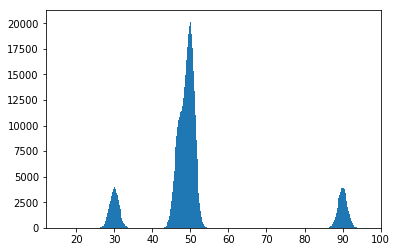

In [7]:
_ = plt.hist(np.asarray(dataTotal).flatten(), bins=300)
plt.xlim(12, 100)

## Rebin data

In [8]:
binsNew, histNew = dhs.rebinEnergyData(binEdgesRandomDict['Slot1'], histList)

(0, 100)

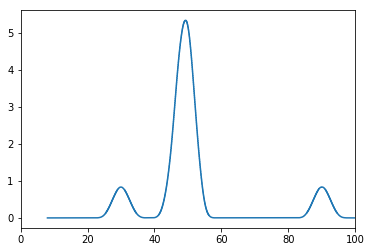

In [9]:
plt.step(binsNew[:-1], histNew, where='post')
plt.xlim(0, 100)

In [10]:
REBINS = 300

flatEdges = np.asarray(binEdgesRandomDict['Slot1']).T[:-1].flatten()
minE, maxE = min(flatEdges), max(flatEdges)

xNew = np.linspace(minE, maxE, REBINS)
yNew = np.nan_to_num(rb.rebin(binsNew, histNew, xNew, interp_kind='piecewise_constant'))

(0, 100)

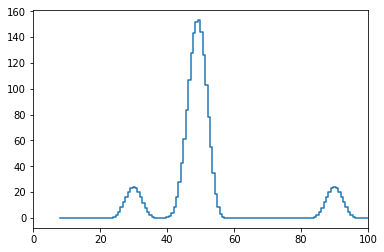

In [11]:
plt.step(xNew[:-1], yNew, where='post')
plt.xlim(0, 100)

((1437.8983516742712, 28.0, 5), array([1498.00728922,   27.65589866,    4.81054356]))
((1445.7909741637386, 48.0, 5), array([1494.86913942,   47.64406462,    4.81748417]))
((1407.1837739295747, 68.0, 5), array([1499.1323648 ,   67.64903052,    4.82380713]))
((1430.9792407889051, 88.0, 5), array([1500.63534466,   87.65514479,    4.80811996]))
((1447.8162366852346, 108.0, 5), array([1491.00910163,  107.64358141,    4.82409113]))
((1420.224723597597, 128.0, 5), array([1500.03828871,  127.64553532,    4.82667011]))
((1421.9942950387483, 148.0, 5), array([1501.5321855 ,  147.65016277,    4.8071561 ]))
((1448.0309338238444, 168.0, 5), array([1490.215215  ,  167.65950396,    4.82490318]))
((1423.9592734244504, 188.0, 5), array([1498.02469656,  187.61915081,    4.83011834]))
4.819210409797499


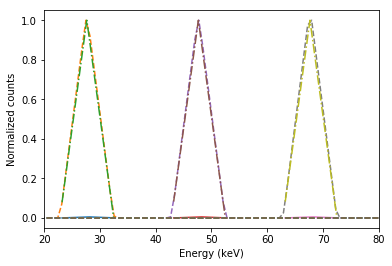

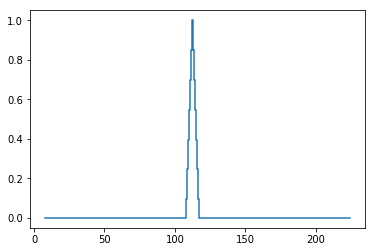

In [12]:
x = np.linspace(minE, maxE, REBINS)
isLarge = np.asarray([pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]])
windowTau = dhs.estimateWindow(x, np.asarray(binEdgesRandomDict['Slot1'])[isLarge], dhs.triangleWindow, meanRange=np.arange(minE + 20, maxE - 20, 20), plot=True)
plt.show()

# Get Window
bins = xNew[:-1]
padFront, padBack = 1000, 1000
xWindow = np.linspace(minE, maxE, len(bins[:-1])) # np.arange(len(bins[:-1]))
yWindow = np.asarray(dhs.triangleWindow(xWindow, 1, .5*maxE, windowTau))
yWindow = 1 * yWindow / float(max(yWindow))

plt.step(xWindow, yWindow, where='post')

In [13]:
maxE, windowTau
sh = int(windowTau / (maxE - minE) * 300)
print sh

6


2299
298
(299, 299)


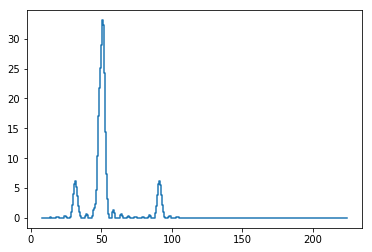

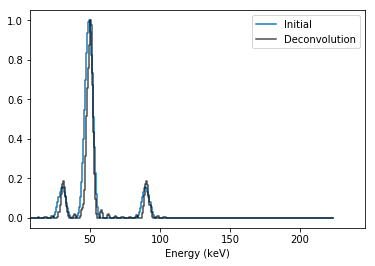

In [14]:
lambd = .1

# Initial data
hist = np.pad(yNew, (padFront, padBack), 'constant', constant_values=(yNew[0], 0))

# Deconvolved data
deconv = dhs.wiener_deconvolution(hist, yWindow, lambd=lambd)
deconv[deconv < 0] = 0    # Reject negative values
# deconv = np.asarray(list(deconv[-maxE//2:]) + list(deconv[:-maxE//2]))
print(len(deconv))
print(len(xWindow))
print(len(xNew[:-1]), len(bins))
plt.step(xNew, deconv[padFront-1-int(len(xNew)/2. - sh):-padBack-int(len(xNew)/2. - sh)], where='post')
plt.show()

# Plot
plt.step(xNew[:-1], yNew / np.max(yNew), where='post', label='Initial')
plt.step(bins, deconv[padFront-int(len(xNew)/2. - sh):-padBack-int(len(xNew)/2. - sh)] / max(deconv), color='k', alpha=.7, label='Deconvolution', where='post')

plt.xlim(0.9 * minE, 1.1 * maxE)
plt.xlabel('Energy (keV)')
plt.legend()
# plt.savefig('deconv.pdf')
plt.show()